In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
import pickle
import re
import seaborn as sns

# Load dataset
data = pd.read_csv('../datasets/Trojan_Detection.csv')
print(f"Original Data Shape: {data.shape}")

ModuleNotFoundError: No module named 'lightgbm'

In [24]:
# Clean column names: remove special characters, leading/trailing spaces, and redundant underscores
data.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in data.columns]  # Replace non-alphanumeric with underscores
data.columns = [re.sub(r'^_+', '', col) for col in data.columns]  # Remove leading underscores
data.columns = [re.sub(r'_+', '_', col) for col in data.columns]  # Replace consecutive underscores with a single one
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Display cleaned column names to verify
print(f"Cleaned Columns: {data.columns}")

Cleaned Columns: Index(['Unnamed_0', 'Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP',
       'Destination_Port', 'Protocol', 'Timestamp', 'Flow_Duration',
       'Total_Fwd_Packets', 'Total_Backward_Packets',
       'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets',
       'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min',
       'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std',
       'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min',
       'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes_s',
       'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max',
       'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std',
       'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean',
       'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags',
       'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s',
       'Min_Packet_Length', 'Max_Packet_Len

In [25]:
# Top 30 features
top_30_features = [
    'Fwd_Packet_Length_Mean', 'Bwd_Packet_Length_Mean', 'Total_Length_of_Bwd_Packets', 
    'Flow_Packets_s', 'Flow_Duration', 'Flow_IAT_Mean', 'Fwd_IAT_Mean', 
    'Flow_Bytes_s', 'Fwd_Packets_s', 'Fwd_IAT_Max', 'Fwd_Packet_Length_Min', 
    'Min_Packet_Length', 'Packet_Length_Mean', 'Fwd_Packet_Length_Std', 
    'Fwd_Packet_Length_Max', 'Total_Length_of_Fwd_Packets', 'Fwd_IAT_Min', 
    'Bwd_Packets_s', 'Flow_IAT_Max', 'Destination_Port', 'Bwd_IAT_Min', 
    'min_seg_size_forward', 'Bwd_Packet_Length_Min', 'Init_Win_bytes_forward', 
    'Init_Win_bytes_backward', 'Flow_IAT_Min', 'Source_Port', 'Source_IP', 'Class',
    'Flow_ID', 'Destination_IP'
]

# Drop columns not in the top 30
data_cleaned = data.drop(columns=[
    col for col in data.columns if col not in top_30_features
], errors='ignore')

# Include additional drops
data_cleaned = data_cleaned.drop(columns=['Unnamed_0', 'Timestamp'], errors='ignore')

print("Remaining columns after dropping non-top 30 features:")
print(data_cleaned.columns)


Remaining columns after dropping non-top 30 features:
Index(['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP',
       'Destination_Port', 'Flow_Duration', 'Total_Length_of_Fwd_Packets',
       'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Min',
       'Bwd_Packet_Length_Mean', 'Flow_Bytes_s', 'Flow_Packets_s',
       'Flow_IAT_Mean', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Mean',
       'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Min', 'Fwd_Packets_s',
       'Bwd_Packets_s', 'Min_Packet_Length', 'Packet_Length_Mean',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Class'],
      dtype='object')


In [26]:
# Save cleaned data to CSV
data_cleaned.to_csv('cleaned_data.csv', index=False)
print(f"Cleaned Data Shape: {data_cleaned.shape}")

Cleaned Data Shape: (177482, 31)


In [27]:
# Encode categorical features
lab = LabelEncoder()
for col in data_cleaned.select_dtypes(include="object").columns:
    data_cleaned[col] = lab.fit_transform(data_cleaned[col])

In [28]:
# Encode target column 'Class'
data_cleaned['Class'] = lab.fit_transform(data_cleaned['Class'])

In [29]:
# Separate features and target
X = data_cleaned.drop(columns='Class')
y = data_cleaned['Class']

In [30]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.80, random_state=42)


In [31]:
# Initialize and train the LightGBM model
model = lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 72623, number of negative: 69362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7043
[LightGBM] [Info] Number of data points in the train set: 141985, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511484 -> initscore=0.045943
[LightGBM] [Info] Start training from score 0.045943


LGBMClassifier(n_estimators=50, random_state=42)

In [32]:
# Save the trained model
with open("lgbm_trojan_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

In [33]:
# Plot feature importances
feature_importances = model.feature_importances_
features = X.columns

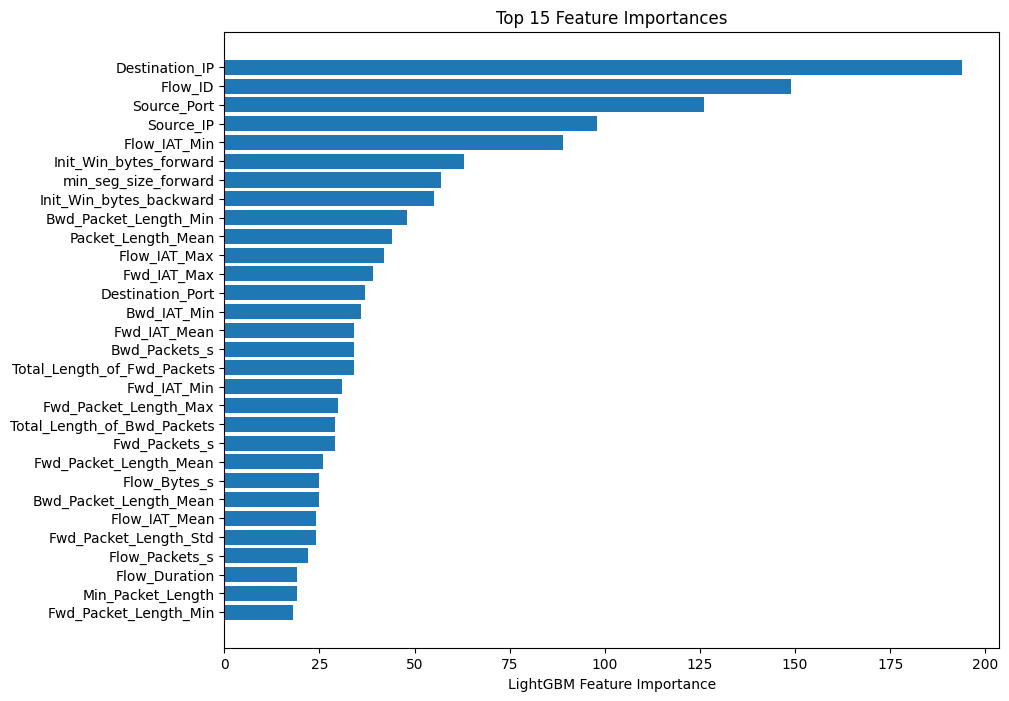

In [34]:
plt.figure(figsize=(10, 8))
sorted_idx = np.argsort(feature_importances)[-30:]  # Top 15 features
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("LightGBM Feature Importance")
plt.title("Top 15 Feature Importances")
plt.show()

In [35]:
top_features = [(features[i], feature_importances[i]) for i in sorted_idx]
with open("top_features.txt", "w") as file:
    file.write("Top 30 Features and Their Importances:\n")
    for feature_name, importance in top_features:
        file.write(f"{feature_name}: {importance}\n")

In [36]:
# Predict on the test set
y_pred = model.predict(x_test)

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


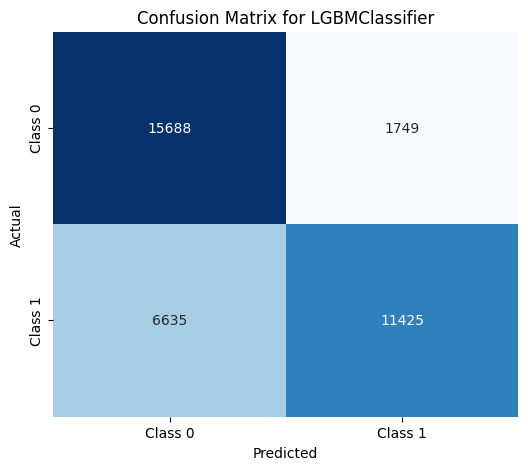

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for LGBMClassifier")
plt.show()

In [39]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report for LGBMClassifier:\n{class_report}')

Classification Report for LGBMClassifier:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79     17437
           1       0.87      0.63      0.73     18060

    accuracy                           0.76     35497
   macro avg       0.79      0.77      0.76     35497
weighted avg       0.79      0.76      0.76     35497



In [40]:
# Save feature names to a text file
with open("feature_names.txt", "w") as feature_file:
    for feature in X.columns:
        feature_file.write(feature + "\n")
print("Model and feature names saved successfully.")

Model and feature names saved successfully.


In [41]:
# Reload the model from the pkl file
with open("lgbm_trojan_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

In [42]:
# Use the reloaded model to predict the test set again
y_pred_loaded = loaded_model.predict(x_test)


In [43]:
# Verify that the predictions match
assert np.array_equal(y_pred, y_pred_loaded), "The predictions from the saved and loaded model do not match."

# Output a message confirming successful predictions
print("Predictions using the reloaded model are consistent with the original model.")

Predictions using the reloaded model are consistent with the original model.
